In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
from project.utils.ds.structures import MaskedExample, Example
from tqdm import tqdm
import dataclasses as dc
from project.utils.ds import images as img_utils
from project.utils.ds import boxes as box_utils
from PIL import ImageOps
import matplotlib.pyplot as plt

In [4]:
train_path = Path("../data/stage1_train/")
test_path = Path("../data/stage1_test/")

We may drop the segmasks from examples, because they fill up the memory too much and seem to not be useful in the detection task.

In [5]:
train_dirs = list(train_path.iterdir())
test_dirs = list(test_path.iterdir())

train_examples = [
    dc.replace(MaskedExample.from_path(p), masks=None)
    for p in tqdm(train_dirs[:])
]

test_examples = [
    Example.from_path(p)
    for p in tqdm(test_dirs[:])
]

len(train_examples), len(test_examples)

100%|██████████| 65/65 [00:00<00:00, 182.72it/s]


(670, 65)

# Visualizations 

Let's plot a few examples

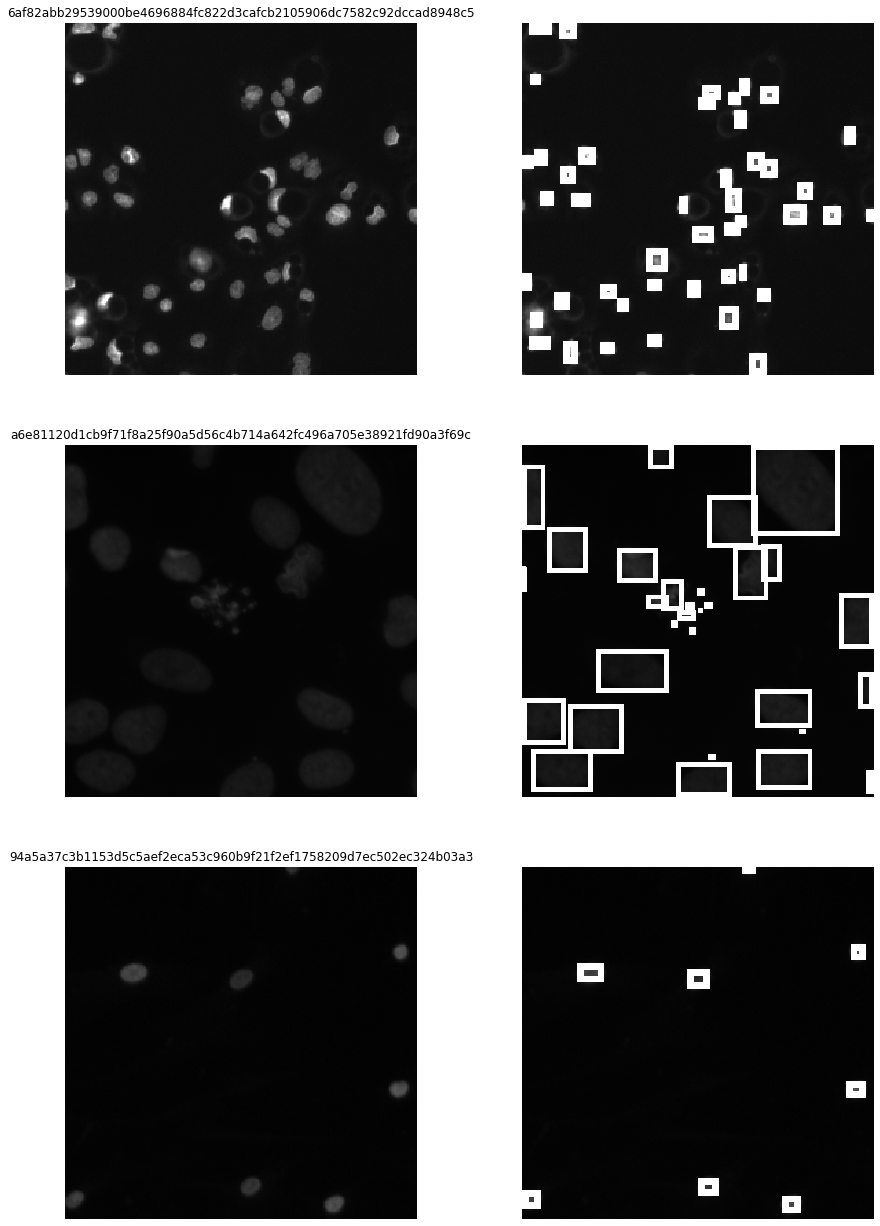

In [6]:
plt.figure(figsize=(15, 22))
for i in range(3):
    
    ex = train_examples[i]
    plt.subplot(3, 2, 1 + 2* i)
    plt.title(ex.name)
    plt.imshow(ex.image)
    plt.axis("off")
    plt.subplot(3, 2, 2 + 2* i)

    plt.imshow(ex.vis_boxes())
    plt.axis("off")

    

We are dealing with images with bounding boxes. 

The images, while RGB, at the first glance seem to be grayscale, with dark background and white dots. Boxes are placed around those dots. Boxes have no classes, so we're dealing with **localization** problem.

# Questions

* photos
     * sizes
     * aspect ratios
     * intensities
         * means
         * stds
         * are they related?
     * types (grayscale, RGB, RGBA)

* objects
    * counts
    * sizes
        * relative to photo size
        * std in a single photo
        * std in the whole dataset
    * shapes
    * coordinates
    * color intensities of box objects 
        * as opposed to the entire image


# Photos

First, let's examine the photos themselves, without their labels. We will examine a couple of photos' features, decide how useful they are and whether the train and test photos are similiar.

## Sizes

$
\text{size} = \sqrt{\text{area}}
$

What are the sizes of photos?



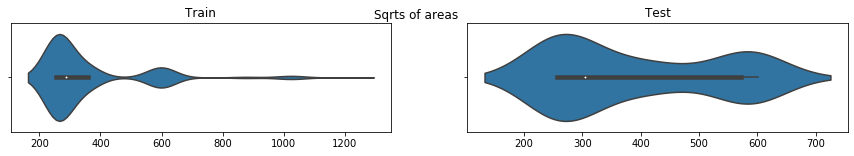

In [7]:
plt.figure(figsize=(15, 2))
plt.suptitle("Sqrts of areas")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot([np.sqrt(np.multiply(*ex.image.size)) for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

sns.violinplot([np.sqrt(np.multiply(*ex.image.size)) for ex in test_examples])

plt.show()

The majority of photos sizes are roughly ~300 pixels, though in both train and test photos there are outliers. 

The train test is more uniform in this regard, so we need to be careful when working on bigger test images. 
We can also consider resizing the images as a part of data preprocessing, which may also be a requirement of our model of choice.

## Aspect ratios
$\text{aspect ratio} = \frac{height}{width}$


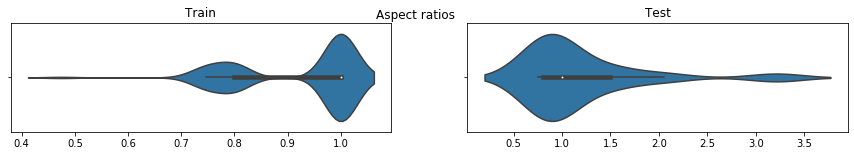

In [8]:

plt.figure(figsize=(15, 2))
plt.suptitle("Aspect ratios")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot([ex.image.height / ex.image.width for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

sns.violinplot([ex.image.height / ex.image.width for ex in test_examples]) 

plt.show()

In both train and test sets, most images seem to have the aspect ratio of 1 - which means they are squares.

## Modes

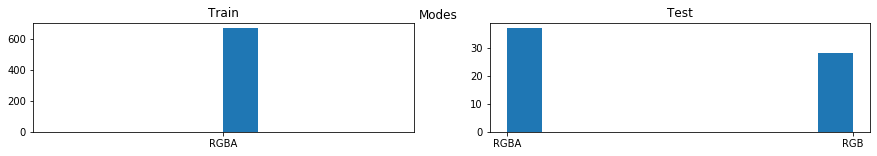

In [9]:
plt.figure(figsize=(15, 2))
plt.suptitle("Modes")
plt.subplot(1, 2, 1)
plt.title("Train")
plt.hist([ex.image.mode for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

plt.hist([ex.image.mode for ex in test_examples]) 

plt.show()

Though images seem to be visually grayscale, their format is mostly RGB or RGBA. That suggests there may potentially be colorful images in the dataset.

## Grayscales

is_grayscale $\rightarrow$ does the numpy array of RGBA image pixels equal the array of pixels after the PIL conversion to grayscale format and back to RGBA?

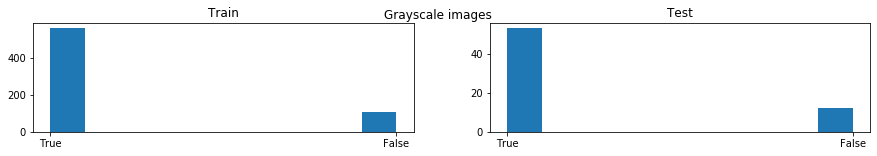

In [10]:
plt.figure(figsize=(15, 2))
plt.suptitle("Grayscale images")
plt.subplot(1, 2, 1)
plt.title("Train")
plt.hist([str(img_utils.is_grayscale(ex.image)) for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

plt.hist([str(img_utils.is_grayscale(ex.image)) for ex in test_examples]) 
plt.show()

Not all images are grayscale!

![](https://live.staticflickr.com/147/388270414_37da11206f_z.jpg)

Let's plot the mean RGB variance - i.e how, in each pixel of the image, the color channels vary. If the mean variance is 0, then all color channels are the same which means the image is grayscale.

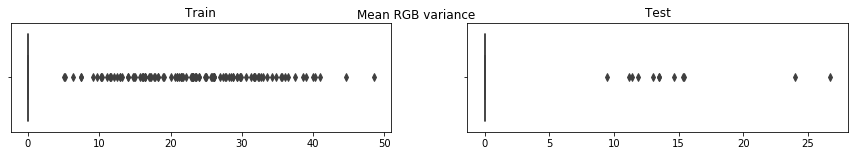

In [11]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean RGB variance")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.boxplot([np.std(ex.image_array[:, :, :3], axis=2).mean() for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

sns.boxplot([np.std(ex.image_array[:, :, :3], axis=2).mean() for ex in test_examples]) 

plt.show()

In both train and test set, most images are grayscale (which is indicated by the box and whiskers of the boxplot concentrated at 0).

Let's examine some of the most colourful examples:

In [12]:
most_variant_examples = sorted(
    train_examples,
    key = lambda ex: np.std(np.asarray(ex.image)[:, :, :3], axis=2).mean(),
    reverse=True
)

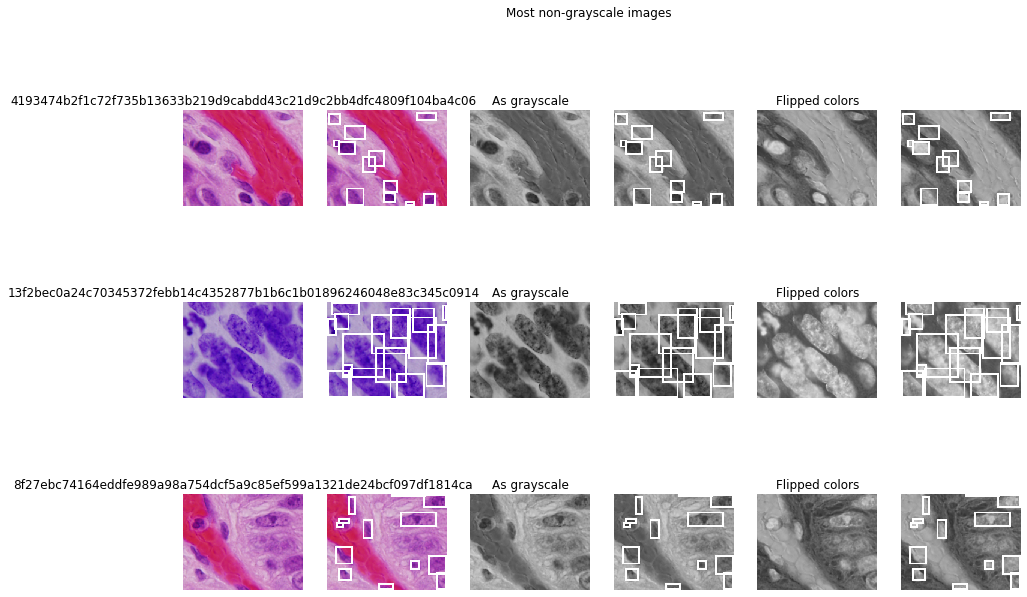

In [13]:
plt.figure(figsize=(15, 10))
plt.suptitle("Most non-grayscale images")
n_rows = 6
for i, ex in enumerate(most_variant_examples[:3]):
    
    plt.subplot(3, n_rows, 1 + n_rows* i)
    plt.title(ex.name)
    plt.imshow(ex.image)
    plt.axis("off")
    plt.subplot(3, n_rows, 2 + n_rows* i)
    plt.imshow(ex.vis_boxes())
    plt.axis("off")

    ex_grayscale = dc.replace(ex, image=ex.image.convert("LA").convert("RGB"))
    plt.subplot(3, n_rows, 3 + n_rows* i)
    plt.title("As grayscale")
    plt.imshow(ex_grayscale.image)
    plt.axis("off")
    plt.subplot(3, n_rows, 4 + n_rows* i)
    plt.imshow(ex_grayscale.vis_boxes())
    plt.axis("off")
    
    ex_flipped = dc.replace(ex_grayscale, image=ImageOps.invert(ex_grayscale.image))
    plt.subplot(3, n_rows, 5 + n_rows* i)
    plt.title("Flipped colors")
    plt.imshow(ex_flipped.image)
    plt.axis("off")
    plt.subplot(3, n_rows, 6 + n_rows* i)
    plt.imshow(ex_flipped.vis_boxes())
    plt.axis("off")

We see a couple of things here:

* indeed, there are some colourful images of the dataset
* the good thing is that it looks like we can convert them to RGB and keep the objects to detect visible
* the bad thing is that after RGB conversion, boxed objects are **darker** than the background - but we thought we were going to detect **brighter objects**?

We'll get back to that later.

## Intensities

In general, how intense (in our case - how bright) are the images?

In [15]:
train_means, test_means = [
    np.array([np.asarray(ex.image.convert("RGB")).mean() for ex in ds])
    for ds in [train_examples, test_examples]
]

train_stds, test_stds = [
    np.array([np.asarray(ex.image.convert("RGB")).std() for ex in ds])
    for ds in [train_examples, test_examples]
]

train_maxs, test_maxs = [
    np.array([np.asarray(ex.image.convert("RGB")).max() for ex in ds])
    for ds in [train_examples, test_examples]
]


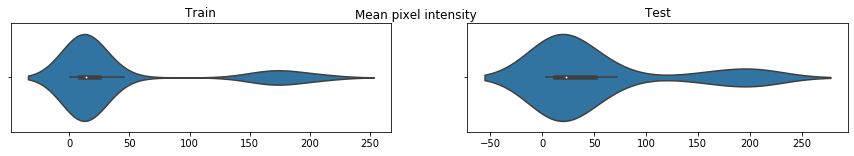

In [16]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot(train_means) 
plt.subplot(1, 2, 2)

plt.title("Test")
sns.violinplot(test_means) 

plt.show()

In general, images are rather dark.

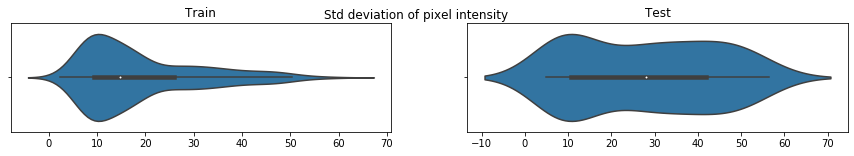

In [17]:
plt.figure(figsize=(15, 2))
plt.suptitle("Std deviation of pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot(train_stds) 
plt.subplot(1, 2, 2)

plt.title("Test")
sns.violinplot(test_stds) 

plt.show()

Intensity of the images doesn't seem to deviate much (though more so in the test set). 

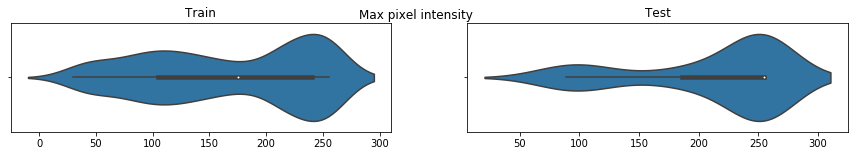

In [21]:
plt.figure(figsize=(15, 2))
plt.suptitle("Max pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot(train_maxs) 
plt.subplot(1, 2, 2)

plt.title("Test")
sns.violinplot(test_maxs) 

plt.show()

Though most of the images are rather dark, most of them **do** posess bright pixels.

Are the mean and std of pixel intensity related?

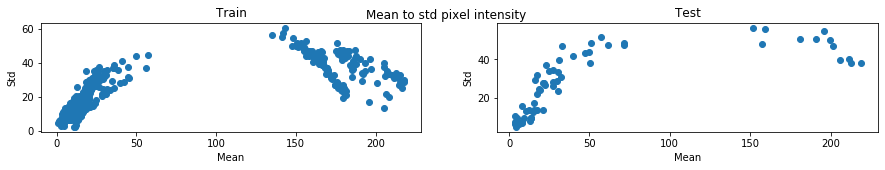

In [19]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean to std pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
plt.xlabel("Mean")
plt.ylabel("Std")
plt.scatter(train_means, train_stds)
plt.subplot(1, 2, 2)

plt.title("Test")
plt.xlabel("Mean")
plt.ylabel("Std")
plt.scatter(test_means, test_stds)

plt.show()

Yes!

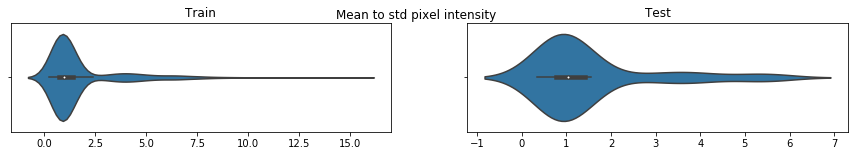

In [20]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean to std pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")

sns.violinplot(train_means / train_stds)
plt.subplot(1, 2, 2)

plt.title("Test")

sns.violinplot(test_means / test_stds)

plt.show()

We see that dividing `mean` intensity by `std` of intensity yields, in general, similar values for all images.

This could mean that the brighter images are, the more their pixels differ from each other. One cause of this could be the backround remaining dark (intensity around 0) and bright objects increasing the mean and std of the intensity.

This gives an idea for a preprocessing step - to normalize the images so that their mean and std are a constant value. This will enhance the brightness dark images without enhancing their background.

# Objects in photos

For this, we only analyze the train set (as this is the only one where we know of objects locations)

## Counts

How many boxes are there in a single image?

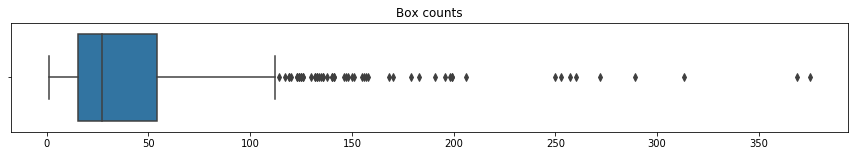

In [23]:
plt.figure(figsize=(15, 2))
plt.title("Box counts")

sns.boxplot([len(ex.boxes) for ex in train_examples])

plt.show()

## Geometric properties

How big are the boxes?

**we consider normalized sizes of the boxes - i.e in range** $(0,1)$ **, as images are of various sizes!**

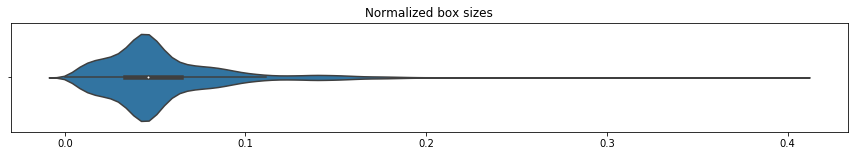

In [24]:
all_boxes = np.concatenate([ex.normed_boxes for ex in train_examples])
areas = box_utils.areas(all_boxes)

plt.figure(figsize=(15, 2))
plt.title("Normalized box sizes")
sns.violinplot(np.sqrt(areas))
plt.show()

Most of the boxes are quite small.

There are also some very tiny boxes, whose areas are nearly 0. For the sake of analysis, we need to filter them out.

In [27]:
all_nonzero_boxes = all_boxes[np.argwhere(areas > 0).reshape(-1)]
all_boxes.shape, all_nonzero_boxes.shape

((29461, 4), (29442, 4))

there are about 20 of such tiny boxes

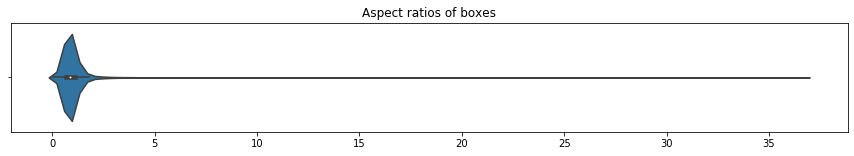

0.9822630392284423

In [28]:
aspect_ratios = box_utils.aspect_ratios(all_nonzero_boxes)
plt.figure(figsize=(15, 2))
plt.title("Aspect ratios of boxes")
sns.violinplot(aspect_ratios)
plt.show()
aspect_ratios.mean()

Aspect ratios of boxes are usually close to 1 - so most boxes are similar to squares.

## Per photo

Let's now examine boxes in their respective photos.

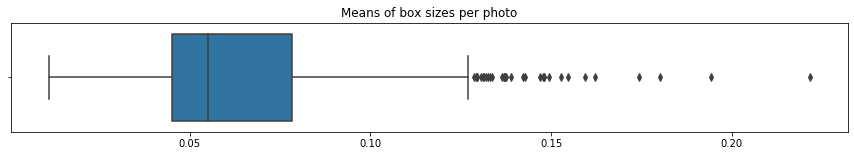

In [29]:
plt.figure(figsize=(15, 2))
plt.title("Means of box sizes per photo")
sns.boxplot([
    np.mean(np.sqrt(box_utils.areas(ex.normed_boxes)))
    for ex in train_examples
])
plt.show()

There is a wide range of mean box sizes for various photos.

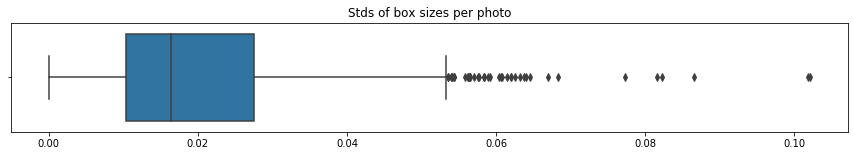

In [30]:
plt.figure(figsize=(15, 2))
plt.title("Stds of box sizes per photo")
sns.boxplot([
    np.std(np.sqrt(box_utils.areas(ex.normed_boxes)))
    for ex in train_examples
])
plt.show()


In various photos, there are different deviations of bo sizes from the mean.

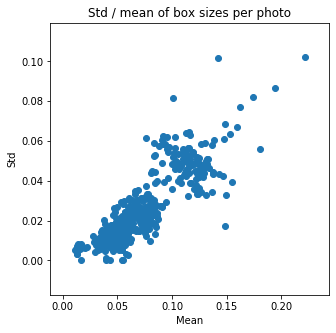

In [32]:
plt.figure(figsize=(5,5))
plt.title("Std / mean of box sizes per photo")
plt.scatter(
    [np.mean(np.sqrt(box_utils.areas(ex.normed_boxes))) for ex in train_examples], 
    [np.std(np.sqrt(box_utils.areas(ex.normed_boxes))) for ex in train_examples]     
)
plt.xlabel("Mean")
plt.ylabel("Std")
plt.show()

We can see, though, that in general, when mean box size increases, so does the std deviation of box sizes in the image. 

This could suggest that boxes in the images belong to similar distributions, but perhaps are photographed at different scales?

**This hints at a way of data augmentation - randomly cropping and/or scaling the images.**

Is there a correlation between the number of boxes in the image and thier size?

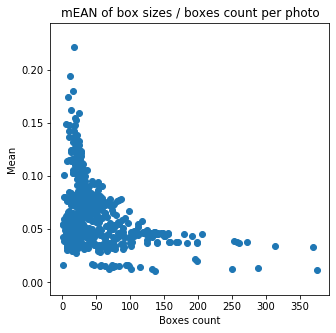

In [38]:
plt.figure(figsize=(5,5))
plt.title("mEAN of box sizes / boxes count per photo")
plt.scatter(
    [len(ex.normed_boxes) for ex in train_examples], 
    [np.mean(np.sqrt(box_utils.areas(ex.normed_boxes))) for ex in train_examples]     
)
plt.xlabel("Boxes count")
plt.ylabel("Mean")
plt.show()

Partially, but nothing concrete.

What about the image size and boxes count?

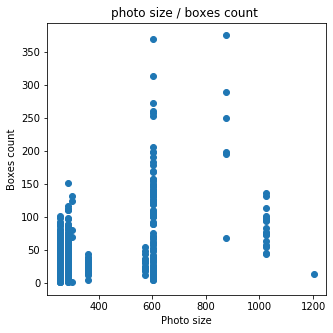

In [39]:
plt.figure(figsize=(5,5))
plt.title("photo size / boxes count ")
plt.scatter(
    [np.sqrt(ex.image.height * ex.image.width) for ex in train_examples], 
    [len(ex.normed_boxes) for ex in train_examples], 
)
plt.ylabel("Boxes count")
plt.xlabel("Photo size")
plt.show()

There seems to be no correlation between boxes counts and photo size, so bigger photos don't contain more boxes.

## Locations

Is there anything we can learn about boxes placements?

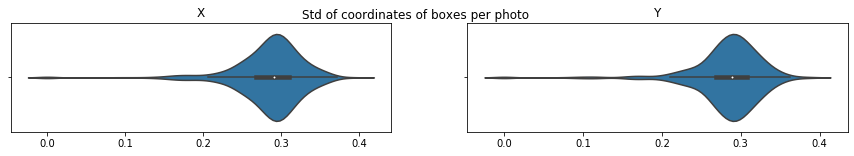

In [40]:
plt.figure(figsize=(15, 2))
plt.suptitle("Std of coordinates of boxes per photo")

plt.subplot(1, 2, 1)
plt.title("X")
sns.violinplot([
    box_utils.centers(ex.normed_boxes)[:,0].std()
    for ex in train_examples
]) 
plt.subplot(1, 2, 2)

plt.title("Y")
sns.violinplot([
    box_utils.centers(ex.normed_boxes)[:,1].std()
    for ex in train_examples
]) 
plt.show()

Boxes are not very clustered, which is a good thing

(long shot) Are boxes aranged in lines?

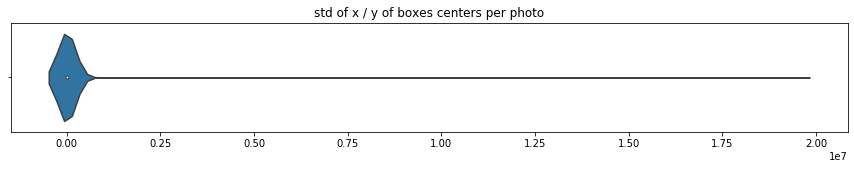

In [41]:
plt.figure(figsize=(15, 2))
plt.title("std of x / y of boxes centers per photo")

sns.violinplot(sorted([
    (box_utils.centers(ex.normed_boxes)[:,0] / (box_utils.centers(ex.normed_boxes)[:,1] + 1e-8)).std()
    for ex in train_examples
])) 


plt.show()

No, they're not.

## Boxes crops analysis

Let's tackle the intensity of objects in boxes vs the intensity of images

In [42]:
mean_img_int = np.array(
    [ex.replace(image=ex.image.convert("RGB")).image_array.mean() for ex in train_examples]
)
mean_img_box_int = np.array([
    np.mean(
        [np.asarray(c.convert("RGB")).mean() for c in ex.boxes_crops if c.height > 0 and c.width > 0]
    ) for ex in train_examples
])

mean_img_int.shape, mean_img_box_int.shape

((670,), (670,))

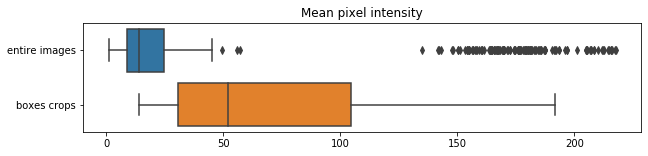

In [43]:
plt.figure(figsize=(10, 2))

# plt.subplot(1, 2, 1)
plt.title("Mean pixel intensity")

sns.boxplot(
    [
        mean_img_int,
        mean_img_box_int
    ],
    [
        "entire images",
        "boxes crops"
    ]
)



On average, box areas are more intense than the mean of the (though there are image outliers)

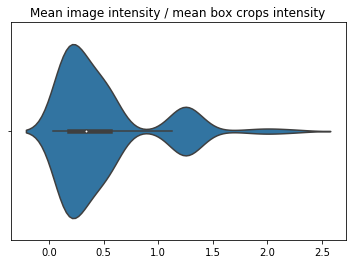

In [46]:
plt.title("Mean image intensity / mean box crops intensity")
sns.violinplot(
    [
        mean_img_int / mean_img_box_int
    ],    
)

On average, an image is less intense than it's boxes.

This confirms that, in general, the objects we have to detect are the bright spots. We need a way to tackle the dark outliers. 

Since we expect the background to be the most of the image, in a valid image, where the spots to detect are bright, the `median` pixel will be less intense than the `mean` pixel. 

A simple preprocessing heuristic could then be to flip colors of the images where this is not the case.